# A deep-learning neural network for image recognition
We present here a `Python Keras` implementation of a deep learning neural network for image recognition.

This is a high-level implementation with the code organised in blocks that resemble the main logical steps involved in developing a deep learning model.

In the next session we'll se the detailed (lower level) implementation, to get a good peek at the code!

The publicly available `MNIST` dataset is used.

`Keras` is a popular `Python` library for deep learning models:
- wrapper for `TensorFlow`
- minimalistic
- modular
- easy to implement

The `MNIST` database (Modified National Institute of Standards and Technology database) is a large database of hand-written digits (details and data [here](http://yann.lecun.com/exdb/mnist/)):

![mnist](https://drive.google.com/uc?id=1KNK3-8qahQixvL-StpDAs6GoOUAHKSDy)

Deep learning consists of neural networks with multiple hidden layers that learn increasingly abstract and complex representations of the input data.
For instance, if we train a deep learning model to recognize hand-written digits (images):

- the first hidden layers might only learn local edge patterns;
- subsequent layers learns more complex representations of the data;
- the last layer will classify the image as one of ten digits.

For image recognition we use a specific deep learning architecture: **convolutional neural networks** (*CNN*), which assume that input data are images, thereby greatly reducing the number of model parameters to be tuned (more on *CNN's* later in the course).


## 1. SET UP

- import libraries
- set seed (for reproducibility)

We use a `Python` script (`support_code.py`) that contains functions used to do these operations transparently for us (behind the scene)

In [5]:
!wget -O support_code.py https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/lab_day1/support_code.py
%run support_code.py

--2025-10-28 14:32:25--  https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/lab_day1/support_code.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6242 (6.1K) [text/plain]
Saving to: ‘support_code.py’

support_code.py     100%[===================>]   6.10K  --.-KB/s    in 0s      

2025-10-28 14:32:25 (99.1 MB/s) - ‘support_code.py’ saved [6242/6242]

Import all libraries: yes
importing libraries
Defining functions
DONE!


The next call to the `reset_random_seed()` function does two things:

1. set three random seeds (python, tensorflow and numpy)
  *   Set the seed using `keras.utils.set_random_seed`. This will set:
      - `numpy` seed
      - `tensorflow` random seed
      - `python` random seed
2. make TensorFlow ops as deterministic as possible, at the cost of affecting the
  overall performance (disabled by default)

In [6]:
n1 = 10
reset_random_seeds(n1)

## 2. LOAD THE DATA: `load_data()`

- choose how many training and test examples to load from the MNIST dataset

We load the data from the MNIST dataset, and assign them to the training and testing sets.

Image data is generally harder to work with than flat relational data. The MNIST dataset is a beginner-friendly intoduction to working with image data: it contains $70\,000$ labeled images of handwritten digits. These are grey-scale images, 28 x 28 pixels.

The MNIST dataset comprises $60\,000$ training observations and $10\,000$ test observations: the function `load_data()` automatically assigns these to the training and testing sets.

In [7]:
ntrain = 20000
ntest = 5000
(X_train, y_train, X_test, y_test) = load_data(ntrain,ntest)

A little sanity check

In [8]:
print("Size of the training set")
print(X_train.shape)
print("Size of the test set")
print(X_test.shape)

Size of the training set
(20000, 28, 28)
Size of the test set
(5000, 28, 28)


Data have been split into a **training** and a **testing set**, and within these into a **three-dimensional array** $X$ of **features** (samples x pixels x pixels) and a vector $y$ of labels (0-9 digits).

Each record in the 3-D array $X$ is a 28 x 28 matrix of grayscale intensities (1 byte = 8 bits = 0 - 255 values). Grayscale (black-n-white) images only use one color channel. Colour images use three channels (e.g. RGB) and each image (record) is therefore a 3-D matrix (pixels x pixels x 3).

Let's have a look at one such image:

First training label:  4


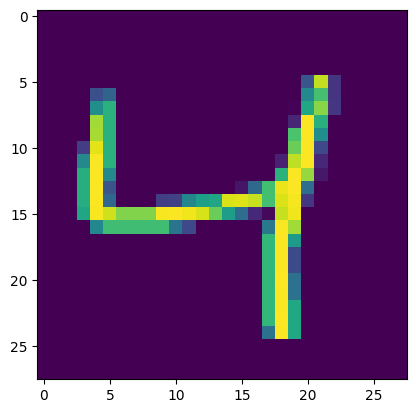

In [9]:
i = 2
print("First training label: ",y_train[i])
plt.imshow(X_train[i, :, :])

By default the matplotlib function `imshow()` uses pseudocolors to plot grayscale images; if you want to display the actual grayscale image, you can specify the color mapping parameters:

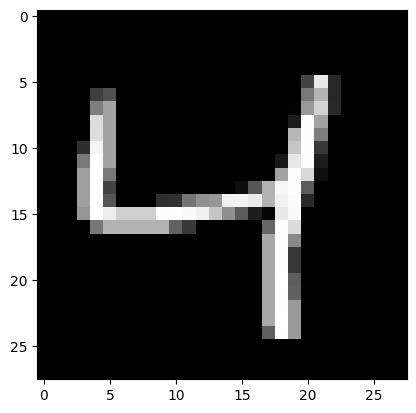

In [10]:
plt.imshow(X_train[2], cmap='gray', vmin=0, vmax=255)

What about the labels?

In [11]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

## 3. CONFIGURE THE PARAMETERS: `set_parameters()`

Define model parameters:

- input shape
- n. of classes: n. of classes to predict (10 digits, in the MNIST problem)
- batch size: DL models typically do not process the entire dataset at once, rather break it in **batches**
- n. of epochs: n. of **iterations** over the entire dataset

In [12]:
(img_rows,img_cols,n_classes,batch_size,n_epochs) = set_parameters(28,28,10,64,20)

## 4. DATA PREPROCESSING: `preprocess()`

- first, we need to explicitly declare the **depth of the image representation** array: in the case of grayscale images there is only one channel, and this dimension is 1
- we then **convert the input data type to `float32`** and **normalize the data** values to the range $[0, 1]$. These are operational modifications necessary to speed up and optimize the calculations.
- finally, **label vectors are converted to class matrices**. This serves to convert a vector of numerical digits to a matrix of ten classes per observation, which is a better suited representation for a classification problem.

In [13]:
(X_train,X_test,y_train,y_test,input_shape) = preprocess(X_train,X_test,y_train,y_test,img_rows,img_cols,n_classes)

declare the correct depth of the image (channels)
normalize input data
prepare the categorical output matrix


In [14]:
print("Modified array dimensions:")
print(X_train.shape)
print(input_shape)

Modified array dimensions:
(20000, 28, 28, 1)
(28, 28, 1)


Let's take a look at the labels matrix (the 'answers'): the first four training examples(labels)

In [15]:
print(y_train[0:4])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Your turn! QUESTION: which digits are these?**

## 5. BUILD THE MODEL: `build_model()`

We now define our deep-learning **neural network architecture**, and start building our model for image recognition.


In [16]:
model = build_model(input_shape, n_classes, n1)

## 6. COMPILE THE MODEL: `compile_model()`

The compilation is the final step in creating a model. Once the compilation is done, we can move on to training phase:

- loss function (objective of the optimizer)
- optimizer (core machinery used to find the weights of the model: learning)
- metrics (used to evaluate the model)

All this pieces are put together (+ the specified network architecture) in the model compilation step.

In [17]:
model = compile_model(model)

model compiled!


In [18]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

None


## 7. TRAIN THE MODEL: `train_model()`

We then fit the model on the training data, specifying:

- the batch size
- the number of epochs to train the model

In [19]:
trained_model = train_model(model,X_train,y_train,batch_size,n_epochs,1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.1153 - loss: 2.3049
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1757 - loss: 2.2732
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2543 - loss: 2.2396
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3210 - loss: 2.2015
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3848 - loss: 2.1578
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4273 - loss: 2.1089
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4626 - loss: 2.0501
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4949 - loss: 1.9841
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5288 - loss: 1.9089
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5532 - loss: 1.8279
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5730 - loss: 1.7441
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

## 8. TEST THE MODEL: `evaluate_model()`

We can now measure the performance (in terms of prediction accuracy) of the trained deep-learning model for image recognition.
To measure the performance, we applied our trained model to independent test data.

In [20]:
(score, confusion_matrix) = evaluate_model(trained_model, X_test, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
model evaluated


Let's look at the eaccuracy of the model:

In [21]:
print(round(score[1],4))

0.7864


And the **confusion matrix**

In [22]:
print(confusion_matrix)

[[433   0   0   2   0   1  16   0   7   1]
 [  0 558   1   6   0   1   3   0   2   0]
 [ 11  12 423  22   2   0  21  19  19   1]
 [  3   6   8 442   0   3   6  17   8   7]
 [  6   7   4   0 339   0  25   2   3 114]
 [ 26  10   2 115  13 207  22  18  29  14]
 [ 30  19  13   0  10   7 380   0   3   0]
 [  6  40  12   4   9   0   2 404   4  31]
 [ 13  26   7  70  10   8  11  16 310  18]
 [ 16  16   5  12  15   1   1  14   4 436]]


### Confusion matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another way to express the accuracy of your predictions. It's a square matrix, with as many rows (and columns) as your classes. Rows represent *true values* and columns represent *predicted values*. On the main diagonal are thus reported the correct predictions, while off-diagonal elements represent errors.

We use the [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function part of [scikit-learn library](https://scikit-learn.org/stable/).

**Your turn! QUESTION: Can you spot the most ambiguous, often confounded classes?**